In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import h5py
import nltk
from collections import Counter
import os
import random
import pickle
import cv2
import json
from tqdm import tqdm
import subprocess

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
train_ds = pd.read_csv("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Train_frameqa_question-balanced.csv", index_col="Unnamed: 0.1")
train_ds.drop(columns=["Unnamed: 0"], inplace=True)
train_ds.tail()

,key,question,answer,vid_id,gif_name,description
159837,ZZXQF-672,"Before consuming some medicine, did they awake...",no,ZZXQF,ZZXQF,none
159838,ZZXQF-573,Was the person wiping anything?,no,ZZXQF,ZZXQF,none
159839,ZZXQF-199,Were they interacting with a vacuum after cons...,no,ZZXQF,ZZXQF,none
159840,ZZXQF-957,"After holding some medicine, which object did ...",mirror,ZZXQF,ZZXQF,none
159841,ZZXQF-994,Was the person watching something in a mirror ...,eating some food,ZZXQF,ZZXQF,none


In [ ]:
train_ds_16k = train_ds.sample(16000, random_state=4213, ignore_index=True).reset_index()
# train_ds_160k.head()
train_ds_16k.to_csv("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Train_frameqa_question-balanced-1p.csv", index=False)

In [4]:
test_ds = pd.read_csv("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Test_frameqa_question-balanced.csv", index_col="Unnamed: 0")
test_ds.head()

,key,question,answer,vid_id,gif_name,description
0,00607-10552,Which object were they tidying before taking t...,table,00607,00607,none
1,00607-11002,Did the person interact with the thing they he...,after,00607,00607,none
2,00607-11005,Did the person interact with the thing they pu...,after,00607,00607,none
3,00607-11006,Were they interacting with the thing they went...,after,00607,00607,none
4,00607-6488,Was interacting with the object they were touc...,before,00607,00607,none


In [ ]:
test_ds_4k = test_ds.sample(4000, random_state=424242, ignore_index=True).reset_index()
test_ds_4k.to_csv("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Test_frameqa_question-balanced-1p.csv", index=False)

In [6]:
del test_ds
del train_ds

In [2]:
train_ds_16k = pd.read_csv("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Train_frameqa_question-balanced.csv")
test_ds_4k = pd.read_csv("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Test_frameqa_question-balanced.csv")

train_sg_pkl = "/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA_scene_graphs/AGQA_train_stsgs.pkl"
test_sg_pkl = "/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA_scene_graphs/AGQA_test_stsgs.pkl"

train_sg_pkl_out = "/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Train_frameqa_question-balanced-1p.pkl"
test_sg_pkl_out = "/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/Test_frameqa_question-balanced-1p.pkl"

In [3]:
vid_ids_train = set(train_ds_16k["vid_id"].unique())
vid_ids_test = set(test_ds_4k["vid_id"].unique())
print(len(vid_ids_train))
print(vid_ids_train)
print(len(vid_ids_test))
print(vid_ids_test)

4970
{'Q4TKG', 'MY5CQ', 'HIJBX', '5LJ3J', 'PM107', 'JCBDT', 'KQNOV', 'LR4XI', 'EZCPC', 'PN7N9', '0M9ZO', 'R2KI4', '52QLH', 'HJJ32', '8M5VK', 'KJK56', 'HC62A', 'VSO80', 'YXJBA', '1N1UT', '49QXY', 'F56YP', 'F4BJJ', 'V10LX', '1SMZZ', '7U43Y', 'TF95Y', '3VRTT', 'VLZ40', '9UU4H', '1L376', 'KLARI', '0R6K4', 'OFB7A', '75GKF', '537I0', '2ECXI', 'NPNB3', 'VX7P0', '3H1EA', 'MU6UQ', 'BYDSE', 'A6CF6', 'WZY7C', 'XW1LX', 'RBC8N', '0XB7U', 'HONL7', 'G2UYF', 'TC3BF', 'WEU2E', 'P4MBS', 'H6OA2', 'FQGQS', '3YNPY', '5KQL2', '16WZF', 'KG20W', 'WOVOX', 'JXS3A', 'BPHWQ', '7ZPHX', 'IN2RL', 'D2T7Z', 'JDG40', 'EQO9N', 'NC1OC', 'AXJUB', 'COPHL', 'XZLNT', '3DO95', '9GOUI', 'K3IGM', 'CFDXI', '5YN7H', 'FB7MZ', 'D0YWV', '86GSE', 'YUCU2', '81R3C', 'ZHGEV', 'A81AV', 'C5LCU', 'KLZN8', 'S1LQF', 'GKH4A', 'TTQ3V', '57QQ7', 'MDOSW', 'S3FY2', 'NR9L2', 'DVDU2', 'JP60G', 'VTEWM', 'USM36', '1E1VE', 'AXYF9', '5OB3W', 'FO035', 'DJ6ZW', 'BE43L', '1K0GV', 'BGX4T', '9HOV3', 'XLQ6X', 'VFS9P', 'ORUV6', '18IDK', '8LWV7', 'QUGLP', 'QGL

In [4]:
import sys
import copy

def filter_pkl(og_pkl_path, out_path, vid_ids):
    with open(og_pkl_path, "rb") as f:
        full_sg = pickle.load(f)
    
    print("Total amount of vids: ", len(full_sg))

    original_limit = sys.getrecursionlimit()
    print(f"OG limit: {original_limit}")
    new_limit = max(original_limit, 10000)
    sys.setrecursionlimit(new_limit)

    filtered_sg = {}
    found_vids = 0
    for video_id in vid_ids:
        if video_id in full_sg:
            filtered_sg[video_id] = copy.deepcopy(full_sg[video_id])
            found_vids += 1
    
    print("Found vids: ", found_vids)

    try:
        with open(out_path, "wb") as f:
            pickle.dump(filtered_sg, f)
    finally:
        sys.setrecursionlimit(original_limit)
        print("restored recursion limit!")

In [10]:
filter_pkl(train_sg_pkl, train_sg_pkl_out, vid_ids_train)
filter_pkl(test_sg_pkl, test_sg_pkl_out, vid_ids_test)

Total amount of vids:  1237
OG limit: 3000
Found vids:  1057
restored recursion limit!
Total amount of vids:  323
OG limit: 3000
Found vids:  323
restored recursion limit!


In [4]:
key_train = list(train_ds_16k["key"].unique())
key_test = list(test_ds_4k["key"].unique())
print(len(key_train))
print(key_train[:5])
print(len(key_test))
print(key_test[:5])

16000
['F1DQD-3798', 'DUHWU-8396', '4LU0G-14022', 'WBATR-19700', '5UNDJ-2303']
4000
['G30NS-55661', 'F19VE-14115', 'RQRRD-22804', 'WXBEO-4352', 'OTUV7-87382']


In [5]:
del train_ds_16k
del test_ds_4k

In [6]:
train_bal_json = pd.read_json("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/train_balanced.txt", orient="index")
train_bal_json["key"] = train_bal_json.index
train_bal_json.head()

,question,answer,video_id,global,local,ans_type,steps,semantic,structural,novel_comp,more_steps,program,sg_grounding,key
46GP8-893,"Of all the items they touched, was the first o...",food,46GP8,"[superlative, obj-rel]",r22-o17-o36-r22-o17-o36-all-,binary,4,object,choose,0,0,"Choose(food, Query(class, OnlyItem(IterateUnti...","{'22-29': ['r22/000091'], '28-28': ['000031', ...",46GP8-893
46GP8-898,"Which were they behind last, some food or a wi...",window,46GP8,"[superlative, obj-rel]",r7-o17-o36-r7-o17-o36-all-,binary,3,object,choose,0,0,"Choose(food, window, IterateUntil(backward, vi...","{'16-22': ['r7/000442'], '26-26': ['000031', '...",46GP8-898
46GP8-899,"In the video, of all the items they went behin...",window,46GP8,"[superlative, obj-rel]",r7-o36-o17-r7-o36-o17-all-,binary,4,object,choose,0,0,"Choose(window, Query(class, OnlyItem(IterateUn...","{'0-12': ['000031', '000091', '000152', '00021...",46GP8-899
46GP8-5,"In the video, did they interact with a window?",yes,46GP8,[exists],yes-no-o36-all-,binary,1,object,verify,0,0,"Exists(window, Iterate(video, Filter(frame, [o...","{'0-12': ['000031', '000091', '000152', '00021...",46GP8-5
46GP8-388,Which object did the person interact with afte...,window,46GP8,[],object,open,3,object,query,0,0,"Query(class, OnlyItem(Iterate(Localize(after, ...","{'48-64': ['c066/1'], '42-64': ['000309', '000...",46GP8-388


In [7]:
train_bal_json = train_bal_json[train_bal_json["key"].isin(key_train)]
print(len(train_bal_json))
train_bal_json.head()

16000


,question,answer,video_id,global,local,ans_type,steps,semantic,structural,novel_comp,more_steps,program,sg_grounding,key
46GP8-5,"In the video, did they interact with a window?",yes,46GP8,[exists],yes-no-o36-all-,binary,1,object,verify,0,0,"Exists(window, Iterate(video, Filter(frame, [o...","{'0-12': ['000031', '000091', '000152', '00021...",46GP8-5
N11GT-3244,"After tidying up the thing they carried, what ...",floor,N11GT,[obj-rel],r8,open,5,object,query,0,0,"Query(class, OnlyItem(Iterate(Localize(after, ...","{'17-39': ['o4/000203', 'o4/000230', 'o4/00025...",N11GT-3244
N11GT-3247,"After tidying up the thing they carried, what ...",broom,N11GT,[obj-rel],v016,open,5,object,query,0,0,"Query(class, OnlyItem(Iterate(Localize(after, ...","{'17-39': ['o4/000203', 'o4/000230', 'o4/00025...",N11GT-3247
KRF68-11896,Before taking the object they were wearing fro...,door,KRF68,[obj-rel],v001,open,5,object,query,0,0,"Query(class, OnlyItem(Iterate(Localize(before,...","{'14-43': ['o10/000360', 'o10/000383', 'o10/00...",KRF68-11896
KRF68-11909,While taking the object they were wearing from...,door,KRF68,[obj-rel],v001,open,5,object,query,0,0,"Query(class, OnlyItem(Iterate(Localize(while, ...","{'13-42': ['o10/000360', 'o10/000383', 'o10/00...",KRF68-11909


In [8]:
train_bal_json.drop(columns=["key"], inplace=True)
train_bal_json.to_json("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/train_balanced-1p.txt", orient="index")

In [9]:
del train_bal_json

In [10]:
test_bal_json = pd.read_json("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/test_balanced.txt", orient="index")
test_bal_json["key"] = test_bal_json.index
test_bal_json.head()

,question,answer,video_id,global,local,ans_type,steps,semantic,structural,novel_comp,...,nc_sup,nc_dur,nc_objrel,indirect,i_obj,i_rel,i_act,i_temp,direct_equiv,key
YSKX3-8,Were they interacting with a blanket while hol...,no,YSKX3,[exists],yes-no-o4-while-c076,binary,3,object,verify,0,...,0,0,0,1,0,0,0,1,YSKX3-9,YSKX3-8
YSKX3-9,Was a blanket one of the things they were inte...,yes,YSKX3,[exists],yes-no-o4-all-,binary,1,object,verify,0,...,0,0,0,0,0,0,0,0,YSKX3-9,YSKX3-9
YSKX3-11,Is there a pillow the person interacts with af...,yes,YSKX3,[exists],yes-no-o26-after-c075,binary,3,object,verify,0,...,0,0,0,1,0,0,0,1,YSKX3-13,YSKX3-11
YSKX3-13,Were they interacting with a pillow?,yes,YSKX3,[exists],yes-no-o26-all-,binary,1,object,verify,0,...,0,0,0,0,0,0,0,0,YSKX3-13,YSKX3-13
YSKX3-461,Was the person holding the first thing they to...,no,YSKX3,"[exists, obj-rel]",yes-no-r15-o4-all-,binary,2,relation,verify,0,...,0,0,0,1,1,0,0,0,YSKX3-446,YSKX3-461


In [11]:
test_bal_json = test_bal_json[test_bal_json["key"].isin(key_test)]
print(len(test_bal_json))
test_bal_json.head()

4000


,question,answer,video_id,global,local,ans_type,steps,semantic,structural,novel_comp,...,nc_sup,nc_dur,nc_objrel,indirect,i_obj,i_rel,i_act,i_temp,direct_equiv,key
YSKX3-3141,Which object did the person touch while taking...,blanket,YSKX3,[obj-rel],r22,open,5,object,query,0,...,0,0,0,1,1,0,0,1,None,YSKX3-3141
T5ECU-1852,Was the person leaning on the object they were...,yes,T5ECU,"[exists, obj-rel]",yes-no-r16-o36-all-,binary,2,relation,verify,1,...,1,0,0,1,1,0,0,0,T5ECU-1784,T5ECU-1852
T5ECU-11610,Between taking a vacuum from somewhere and smi...,window,T5ECU,[obj-rel],r16,open,5,object,query,0,...,0,0,0,1,0,0,0,1,T5ECU-11591,T5ECU-11610
T5ECU-11617,Which object did the person sit on before star...,chair,T5ECU,[obj-rel],r20,open,4,object,query,0,...,0,0,0,1,0,0,0,1,None,T5ECU-11617
T5ECU-11829,"Before starting to stand up, which was the per...",window,T5ECU,[obj-rel],r16-o8-o36-r16-o8-o36-before-c154,binary,6,object,choose,1,...,0,0,1,1,1,0,0,1,None,T5ECU-11829


In [ ]:
test_bal_json.drop(columns=["key"], inplace=True)
test_bal_json.to_json("/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/AGQA2_balanced/test_balanced-1p.txt", orient="index")

In [13]:
del test_bal_json

In [4]:
video_path = "/home/javid/Downloads/Charades_v1_480/"
out_path = "/home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/video_features/video_secs.json"

In [5]:
vid_ids = vid_ids_train.union(vid_ids_test)
del vid_ids_train
del vid_ids_test

In [6]:
print(len(vid_ids))
print(vid_ids)

6191
{'WSLMS', 'Q4TKG', 'WHRBU', 'MY5CQ', 'TCOXG', '9XOED', 'HIJBX', '5LJ3J', 'PM107', 'MRKTD', '3IAPG', 'JCBDT', 'KQNOV', 'LR4XI', 'EZCPC', '1XOQ8', 'PN7N9', '0M9ZO', 'E40Y8', 'R2KI4', '52QLH', 'HJJ32', '8M5VK', 'IALUY', 'F75LG', 'KJK56', 'W6QUC', 'HC62A', 'I80TD', '3OZUX', 'VSO80', 'YXJBA', '1N1UT', '49QXY', 'F56YP', 'I5MMK', 'H411A', 'F4BJJ', 'V10LX', '1SMZZ', 'Z3DBQ', '7U43Y', 'TF95Y', 'EHS68', '3VRTT', 'DICXG', '7UZZI', 'KAQNT', 'VLZ40', 'E7FGK', 'RMKOC', '9UU4H', 'XEASG', '1L376', '08EPO', '3AHLN', 'JMPKP', 'KLARI', '0R6K4', 'OFB7A', 'OJLFZ', 'J0JD1', '75GKF', '537I0', 'BOOKV', 'G8NEV', '2ECXI', 'NPNB3', 'AL1WC', '5IDF4', '41II2', 'R5CWJ', 'VX7P0', '3H1EA', 'LG7WK', 'QN42P', 'N9VOV', 'MU6UQ', 'I0HIX', 'I87SH', 'BYDSE', '7LWW3', '43CCM', 'A6CF6', 'RJIEO', 'OUAIS', 'WZY7C', '3S6WL', '8S941', '3IPI3', 'XW1LX', '21WN7', 'RBC8N', '0XB7U', '7WOW1', '3QGLU', '279W6', 'HONL7', 'E9UYZ', '1X7OW', 'G2UYF', 'FIV2P', 'VA8NL', 'TC3BF', '8AKGE', '43OGO', 'WEU2E', 'GHC5X', 'Z2DEZ', '386XM', 'TTL

In [8]:
def get_vid_duration(video_path):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", video_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT)
    return float(result.stdout)


In [9]:
video_durations = {}
processed_count = 0
missing_count = 0

# progress bar
# why? for fun
for video_id in tqdm(vid_ids, desc="Processing videos"):
    vid_path =os.path.join(video_id, f'{video_path}/{video_id}.mp4')

    if os.path.isfile(vid_path):
        duration = get_vid_duration(vid_path)
        video_durations[video_id] = duration
        processed_count +=1
    else:
        print(f"Video not found for ID {video_id}")
        missing_count +=1
    
print("Finished processing.")
print(f"Calculated durations for {processed_count} videos.")

if missing_count > 0:
    print(f"Missing {missing_count} videos.")

Processing videos: 100%|██████████| 6191/6191 [09:52<00:00, 10.46it/s]

Finished processing.
Calculated durations for 6191 videos.


In [10]:
try:
    with open(out_path, "w") as f:
        json.dump(video_durations, f, indent=4)
    print(f"Saved video durations to {out_path}")
except:
    print("Failed to save video durations")

Saved video durations to /home/javid/Documents/UFAZ/res_stair/STAIR/data/AGQA/video_features/video_secs.json


In [12]:
print(video_durations["WSLMS"])


30.672993


In [1]:
text = "0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.038691 0.08153 0.14667 0.063666 0.061332 -0.075569 -0.37724 0.01585 -0.30342 0.28374 -0.042013 -0.040715 -0.15269 0.07498 0.15577 0.10433 0.31393 0.19309 0.19429 0.15185 -0.10192 -0.018785 0.20791 0.13366 0.19038 -0.25558 0.304 -0.01896 0.20147 -0.4211 -0.0075156 -0.27977 -0.19314 0.046204 0.19971 -0.30207 0.25735 0.68107 -0.19409 0.23984 0.22493 0.65224 -0.13561 -0.17383 -0.048209 -0.1186 0.0021588 -0.019525 0.11948 0.19346 -0.4082 -0.082966 0.16626 -0.10601 0.35861 0.16922 0.07259 -0.24803 -0.10024 -0.52491 -0.17745 -0.36647 0.2618 -0.012077 0.08319 -0.21528 0.41045 0.29136 0.30869 0.078864 0.32207 -0.041023 -0.1097 -0.092041 -0.12339 -0.16416 0.35382 -0.082774 0.33171 -0.24738 -0.048928 0.15746 0.18988 -0.026642 0.063315 -0.010673 0.34089 1.4106 0.13417 0.28191 -0.2594 0.055267 -0.052425 -0.25789 0.019127 -0.022084 0.32113 0.068818 0.51207 0.16478 -0.20194 0.29232 0.098575 0.013145 -0.10652 0.1351 -0.045332 0.20697 -0.48425 -0.44706 0.0033305 0.0029264 -0.10975 -0.23325 0.22442 -0.10503 0.12339 0.10978 0.048994 -0.25157 0.40319 0.35318 0.18651 -0.023622 -0.12734 0.11475 0.27359 -0.21866 0.015794 0.81754 -0.023792 -0.85469 -0.16203 0.18076 0.028014 -0.1434 0.0013139 -0.091735 -0.089704 0.11105 -0.16703 0.068377 -0.087388 -0.039789 0.014184 0.21187 0.28579 -0.28797 -0.058996 -0.032436 -0.0047009 -0.17052 -0.034741 -0.11489 0.075093 0.099526 0.048183 -0.073775 -0.41817 0.0041268 0.44414 -0.16062 0.14294 -2.2628 -0.027347 0.81311 0.77417 -0.25639 -0.11576 -0.11982 -0.21363 0.028429 0.27261 0.031026 0.096782 0.0067769 0.14082 -0.013064 -0.29686 -0.079913 0.195 0.031549 0.28506 -0.087461 0.0090611 -0.20989 0.053913"
test = text.split(" ")
len(test)

300

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
train_loss_path = "/home/javid/Downloads/run-.-tag-loss_decoder.csv"
val_loss_path = "/home/javid/Downloads/run-.-tag-valid_decoder.csv"
val_acc_path = "/home/javid/Downloads/run-.-tag-valid_acc.csv"

step_col = 'Step'
value_col = 'Value'

In [6]:
def load_csv(path, step_col, value_col):
    df = pd.read_csv(path)
    df = df.sort_values(by=step_col)
    return df

In [9]:
train_loss_df = load_csv(train_loss_path, step_col, value_col)
val_loss_df = load_csv(val_loss_path, step_col, value_col)
val_acc_df = load_csv(val_acc_path, step_col, value_col)

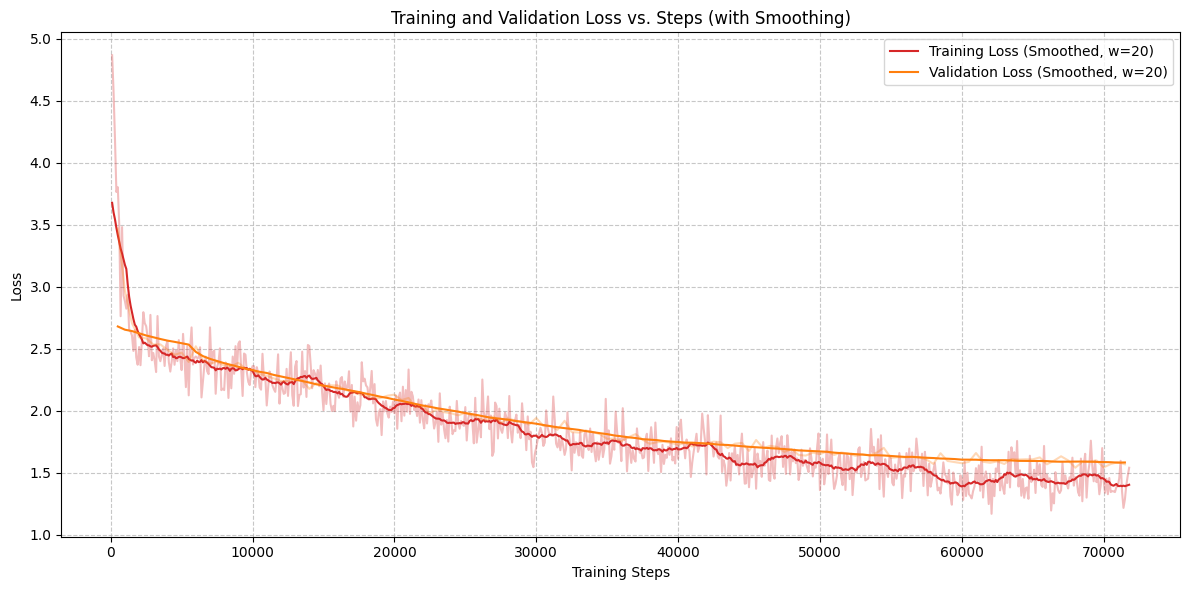

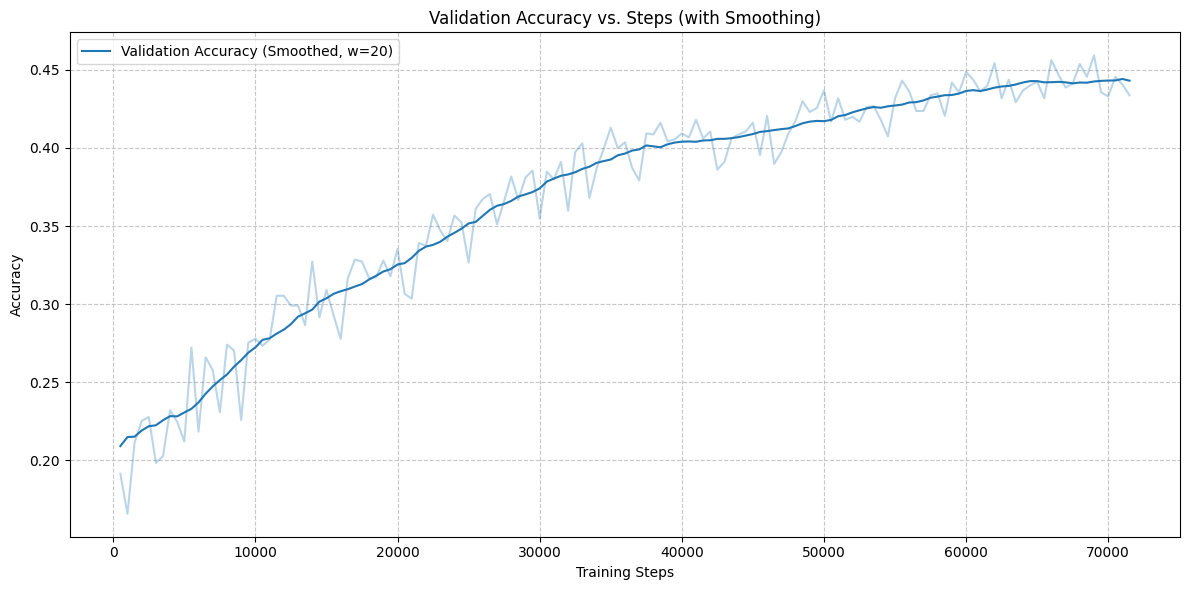

In [15]:
if True:
    smoothing_window_size = 20
    # Calculate smoothed values using rolling average
    # Note: .rolling().mean() produces NaN for the first (window_size - 1) points
    train_loss_smooth = train_loss_df[value_col].rolling(window=smoothing_window_size, min_periods=1, center=True).mean()
    valid_loss_smooth = val_loss_df[value_col].rolling(window=smoothing_window_size, min_periods=1, center=True).mean()
    valid_acc_smooth  = val_acc_df[value_col].rolling(window=smoothing_window_size, min_periods=1, center=True).mean()
    # Using center=True provides a potentially nicer alignment, min_periods=1 ensures output starts earlier


    # === Plot 1: Training and Validation Loss ===
    fig1, ax_loss = plt.subplots(figsize=(12, 6))

    # Plot original training loss (lighter, thinner)
    ax_loss.plot(train_loss_df[step_col], train_loss_df[value_col], color='tab:red', linestyle='-', alpha=0.3)
    # Plot smoothed training loss (stronger)
    ax_loss.plot(train_loss_df[step_col], train_loss_smooth, color='tab:red', linestyle='-', label=f'Training Loss (Smoothed, w={smoothing_window_size})')

    # Plot original validation loss (lighter, thinner)
    ax_loss.plot(val_loss_df[step_col], val_loss_df[value_col], color='tab:orange', linestyle='-', alpha=0.3)
    # Plot smoothed validation loss (stronger)
    ax_loss.plot(val_loss_df[step_col], valid_loss_smooth, color='tab:orange', linestyle='-', label=f'Validation Loss (Smoothed, w={smoothing_window_size})')

    # Customize loss plot
    ax_loss.set_xlabel('Training Steps')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Training and Validation Loss vs. Steps (with Smoothing)')
    ax_loss.legend(loc='best')
    ax_loss.grid(True, linestyle='--', alpha=0.7)
    # Optional: Set y-limit if noise is extreme or early values are very high
    # ax_loss.set_ylim(bottom=0) # Example: force y-axis to start at 0
    fig1.tight_layout()


    # === Plot 2: Validation Accuracy ===
    fig2, ax_acc = plt.subplots(figsize=(12, 6))

    # Plot original validation accuracy (lighter, thinner)
    ax_acc.plot(val_acc_df[step_col], val_acc_df[value_col], color='tab:blue', linestyle='-', alpha=0.3)
    # Plot smoothed validation accuracy (stronger)
    ax_acc.plot(val_acc_df[step_col], valid_acc_smooth, color='tab:blue', linestyle='-', label=f'Validation Accuracy (Smoothed, w={smoothing_window_size})')

    # Customize accuracy plot
    ax_acc.set_xlabel('Training Steps')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_title('Validation Accuracy vs. Steps (with Smoothing)')
    ax_acc.legend(loc='best')
    ax_acc.grid(True, linestyle='--', alpha=0.7)
    # Optionally set y-axis limits for accuracy
    # ax_acc.set_ylim(0, 1) # If accuracy is 0-1
    # ax_acc.set_ylim(0, 100) # If accuracy is 0-100
    fig2.tight_layout()


    # Display both plots
    plt.show()